In [1]:
import os
import glob

# packs from my setup
songs_path = 'C:\\Users\\Lenovo\\AppData\\Roaming\\ITGmania\\Songs'
pack_names = [
    'Stamina RPG 6',
    'SRPG6 NNP',
    'Stamina RPG 7',
    'Stamina RPG 7 - SN',
    'Stamina RPG 7 - FE',
    'Stamina RPG 8',
    'Stamina RPG 8 - SN',
    'Stamina RPG 8 - FE',
    'Stamina RPG 9',
    'Stamina RPG 9 - SN',
    'Stamina RPG 9 - FE',
]
pack_paths = [os.path.join(songs_path, name) for name in pack_names]

glob_path = '.\\packs\\*'
pack_paths += glob.glob(glob_path)
# pack_paths = ['.\\packs\\In The Groove']

In [4]:
import math
from typing import Iterable, Iterator
from collections import deque

SPACING = 1
SUPPORT_RADIUS = 1.5 * SPACING
def _kernel(x):
    x = (x / SPACING) + 1.5
    if x <= 1:
        y = x * x / 2
    elif x <= 2:
        y = (2 - x) * (x - 1) + 0.5
    else:
        x = x - 3
        y = x * x / 2
    return y / SPACING

def get_seq(note_times: Iterable[float]) -> Iterator[float]:
    note_times = iter(note_times)
    queue = deque()
    # raises StopIteration if note_times is empty, which is desired
    first = next(note_times, None)
    if first is None:
        return
    sample_loc = math.ceil((first - SUPPORT_RADIUS) / SPACING) * SPACING
    queue.append(first)
    while queue:
        lbound = sample_loc - SUPPORT_RADIUS
        rbound = sample_loc + SUPPORT_RADIUS
        # add new notes, ensuring last note in queue is beyond the
        # window, if possible
        if queue[-1] < rbound:
            next_note = next(note_times, None)
            while next_note is not None and next_note < rbound:
                queue.append(next_note)
                next_note = next(note_times, None)
            if next_note is not None:
                queue.append(next_note)
        # clear old notes
        while queue and queue[0] < lbound:
            queue.popleft()

        accum = 0
        for time in queue:
            if time < rbound:
                accum += _kernel(sample_loc - time)
        yield accum
        sample_loc += SPACING

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
def extract_features(seq: list[float]):
    max_nps = max(seq)
    length = len(seq)
    cum_nps_per_bin = [0 for _ in THRESHOLDS]
    count_per_bin = [0 for _ in THRESHOLDS]
    # num of samples where NPS > the threshold (fraction of max NPS)
    threshold_counts = [0 for _ in THRESHOLDS]
    segs_per_thresh = [[] for _ in THRESHOLDS]
    for nps in seq:
        for thresh_i, thresh in enumerate(THRESHOLDS):
            segs = segs_per_thresh[thresh_i]
            if nps > thresh * max_nps:
                threshold_counts[thresh_i] += 1
                if not segs or segs[-1] < 0: # if prev was break, start a new seg
                    segs.append(0)
                segs[-1] += 1
            else:
                if not segs or segs[-1] > 0: # if prev was a block, start a new seg
                    segs.append(0)
                segs[-1] -= 1
        bin_i = -1
        for thresh in THRESHOLDS:
            if nps > thresh * max_nps:
                bin_i += 1
            else:
                break
        if bin_i > -1:
            cum_nps_per_bin[bin_i] += nps
            count_per_bin[bin_i] += 1
    
    default_avg_nps = [x * max_nps for x in (0.1, 0.3, 0.5, 0.7, 0.9)]
    avg_nps_per_bin = [
        (cum_nps / count if count > 0 else default)
        for cum_nps, count, default in zip(cum_nps_per_bin, count_per_bin, default_avg_nps)
    ]

    density_per_bin = []
    for segs, count in zip(segs_per_thresh, threshold_counts):
        total_len = length
        if segs:
            if segs[0] < 0:
                total_len += segs[0]
            if len(segs) > 1 and segs[-1] < 0:
                total_len += segs[-1]
            density_per_bin.append(count / total_len)
        else:
            density_per_bin.append(0)


    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[0 for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    for thresh_i, thresh in enumerate(THRESHOLDS):
        segs = segs_per_thresh[thresh_i]
        for break_i, break_len in enumerate(BREAK_LENGTHS):
            cur_block = 0
            longest_block = 0
            for seg in segs:
                assert seg != 0
                if seg > 0: # is block
                    cur_block += seg
                elif -seg > break_len: # is break
                    # end block
                    longest_block = max(longest_block, cur_block)
                    cur_block = 0
            longest_block = max(longest_block, cur_block)
            longest_blocks[thresh_i][break_i] = longest_block

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin,
        *(math.log2(x+1) for row in longest_blocks for x in row)
    ]

data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
columns = [
    'Name', 'Hash', 'Meter',
    *data_columns
]

In [3]:
import numpy as np
np.asarray(list(get_seq(np.arange(0.23, 6, 1/16.4)))) - 16.4

array([-1.63266138e+01, -1.06115380e+01, -9.33946758e-01,  2.05294468e-04,
       -1.81499108e-04,  9.82153480e-05, -3.56637210e-01, -8.29606187e+00,
       -1.60753244e+01, -1.64000000e+01])

In [27]:
list(get_seq([]))

[]

In [5]:
from simfile.dir import SimfilePack
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import pandas as pd
import math
import itertools
import simfile

try:
    existing_df = pd.read_csv('seq_dataset.csv')
    seen_hashes = set(existing_df['Hash'])
except FileNotFoundError:
    existing_df = None
    seen_hashes = set()

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        note_times = chart_analyzer.get_note_times()
        seq = list(get_seq(note_times))
        if not seq:
            print(title, ': empty?')
            continue
        # print(seq)

        data.append((
            title,
            chart_hash,
            meter,
            seq
        ))
    return data

data = []
for pack_path in pack_paths:
    pack = SimfilePack(pack_path)
    for song in pack.simfiles(strict=False):
        data.extend(handle_song(song, pack.name, seen_hashes))
misc_sim_paths = glob.glob('.\\packs\\_misc\\*')
for path in misc_sim_paths:
    song = simfile.open(path, strict=False)
    data.extend(handle_song(song, '_misc', seen_hashes))

c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


analyzing Stamina RPG 6/[11] [128] Alcohol-Free
analyzing Stamina RPG 6/[11] [136] Cowboy
analyzing Stamina RPG 6/[11] [136] Flutterwonder (Hard)
analyzing Stamina RPG 6/[11] [124] Glory Days
analyzing Stamina RPG 6/[11] [145] Hawaiian Roller Coaster Ride (Medium)
analyzing Stamina RPG 6/[11] [130] Helix (Hard)
analyzing Stamina RPG 6/[11] [131] In The Game (The Football Song)
analyzing Stamina RPG 6/[11] [145] Kislotnyy Dozhd (Medium)
analyzing Stamina RPG 6/[11] [120] Le Perv
analyzing Stamina RPG 6/[11] [124] Lonely
analyzing Stamina RPG 6/[11] [145]  Move That Body!
analyzing Stamina RPG 6/[11] [147] This game (Hard)
analyzing Stamina RPG 6/[11] [128] We Are Giants (feat. Dia Frampton)
analyzing Stamina RPG 6/[12] [138] Cake By The Ocean
analyzing Stamina RPG 6/[12] [174] Gargantua
analyzing Stamina RPG 6/[12] [160] Gimme Your Desire (Hard)
analyzing Stamina RPG 6/[12] [140] Higanbana
analyzing Stamina RPG 6/[12] [156] I Want U
analyzing Stamina RPG 6/[12] [135] I'm Coming
analyzin

In [6]:
columns = ['Name', 'Hash', 'Meter', 'Seq']
df = pd.DataFrame(data, columns=columns)
if existing_df is not None:
    df = pd.concat([existing_df, df], axis=0, ignore_index=True)
df

,Name,Hash,Meter,Seq
0,Stamina RPG 6/[11] [128] Alcohol-Free,0b020e29c3919c10c1d3fb2776e813b18af30114,11,"[4.050000000000307e-05, 1.7252810859375018, 7...."
1,Stamina RPG 6/[11] [136] Cowboy,f2bc769bdf7addfc64d7e46643e194f184820a56,11,"[0.3188346366782005, 4.846108878892734, 7.9326..."
2,Stamina RPG 6/[11] [136] Flutterwonder (Hard),fc05556c0b501fabafe79a16923e910518d5d03d,11,"[0.044209385813148656, 0.7089341695501729, 0.5..."
3,Stamina RPG 6/[11] [124] Glory Days,c0b5988bae418d86ccac7c7209f605932857bb81,11,"[0.19957966077003164, 2.5900707221644113, 4.11..."
4,Stamina RPG 6/[11] [145] Hawaiian Roller Coast...,d0b51e7437f6705f45bf6d9c1254964330bfcc4e,11,"[0.5023429762187873, 5.083400186682522, 6.9295..."
...,...,...,...,...
3132,_misc/140BPM Stamina Killer,b9c0db86a2e1346db5967b712aeb1ff876154c28,21,"[0.7937520714285716, 6.686947795918368, 9.3222..."
3133,_misc/[Marathon] Life Starts At 200 BPM,c2dcb36e047968bc2ece44ae23503e5b3b1e9bb9,23,"[0.04500000000000001, 0.7949999999999999, 2.02..."
3134,_misc/[2017] Pure Madness,99c6d44a2f7c78ef43116759c30013aaf04cee5a,24,"[3.199999999999295e-05, 2.049368531249995, 8.3..."
3135,_misc/[2017] XS Project Collection Full,74c5e5a6f705318b47b969ef158a3b448faa04ee,21,"[0.21470472866087098, 1.529906647380748, 1.443..."


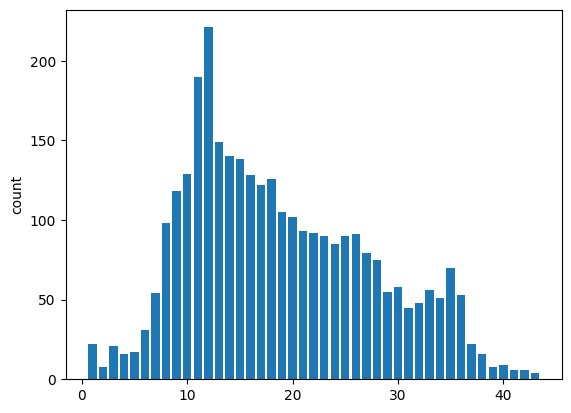

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

meter_counts = df['Meter'].value_counts().sort_index()
meters = meter_counts.index.to_numpy()
counts = meter_counts

ax.bar(meters, counts)

ax.set_ylabel('count')

plt.show()

In [8]:
np.unique_counts(df['Meter'].to_numpy())

AttributeError: module 'numpy' has no attribute 'unique_counts'

In [9]:
df.to_csv('seq_dataset.csv', index=False)

## umap

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('nn_dataset.csv')

In [6]:
import umap

In [7]:
reducer = umap.UMAP()

In [8]:
from sklearn.preprocessing import StandardScaler

limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
data = df[data_columns].values
scaled_data = StandardScaler().fit_transform(data)

In [9]:
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(4105, 2)

Text(0.5, 1.0, 'UMAP projection of the dataset')

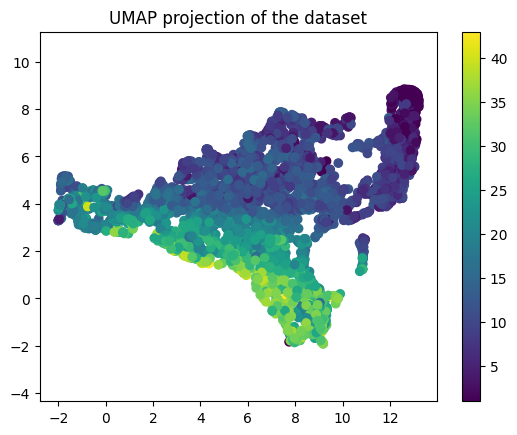

In [11]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=df['Meter'])
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the dataset')

In [12]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper

output_notebook()

Loading BokehJS ...

In [13]:
from bokeh import palettes

def bokeh_display(xy_df, palette=palettes.Turbo256):
    embedding_df = xy_df
    embedding_df['name'] = df['Name']
    embedding_df['meter'] = df['Meter']

    datasource = ColumnDataSource(embedding_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        title='UMAP projection of the dataset',
        width=800,
        height=600,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@meter]</span>
            <span style='font-size: 12px'>@name</span>
        </div>
    </div>
    """))

    plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.8,
        size=8
    )
    show(plot_figure)

bokeh_display(pd.DataFrame(embedding, columns=('x', 'y')), palette=palettes.Turbo256*2)

In [15]:
xy = pd.DataFrame()
xy['x'] = df['N_0.8']
xy['y'] = df['T_0.8']
bokeh_display(xy,
              palette=palettes.Turbo256*4)

In [176]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
mm_scaler = StandardScaler()
mm_scaled_data = mm_scaler.fit_transform(data)

# Perform PCA Decomposition on both train and test sets
# Note that we fit PCA on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
pca = PCA(n_components=2)
pca_data = pca.fit_transform(mm_scaled_data)

bokeh_display(pd.DataFrame(pca_data, columns=('x', 'y')), palette=palettes.Turbo256)